![walmartecomm](walmartecomm.jpg)

Walmart is the biggest retail store in the United States. Just like others, they have been expanding their e-commerce part of the business. By the end of 2022, e-commerce represented a roaring $80 billion in sales, which is 13% of total sales of Walmart. One of the main factors that affects their sales is public holidays, like the Super Bowl, Labour Day, Thanksgiving, and Christmas. 

In this project, I will be creating a data pipeline for the analysis of supply and demand around the holidays, along with conducting a preliminary analysis of the data. I will be working with two data sources: grocery sales and complementary data. 

In [48]:
# Import the libraries
import pandas as pd
import os

#Load the dataset
grocery_sales = pd.read_csv('grocery_sales.csv')

In [49]:
# Extract function
def extract(store_data, extra_data):
    extra_df = pd.read_parquet(extra_data)
    merged_df = store_data.merge(extra_df, on = "index")
    return merged_df

# Call the extract() function and store it as the "merged_df" variable
merged_df = extract(grocery_sales, "extra_data.parquet")

In [50]:
# Create the transform() function with one parameter: "raw_data"
def transform(raw_data):
  # Fill NaNs using mean since we are dealing with numeric columns
  # Set inplace = True to do the replacing on the current DataFrame
    raw_data.fillna(
      {
          'CPI': raw_data['CPI'].mean(),
          'Weekly_Sales': raw_data['Weekly_Sales'].mean(),
          'Unemployment': raw_data['Unemployment'].mean(),
      }, inplace = True
    )
    
# Define the type of the "Date" column and its format
    raw_data["Date"] = pd.to_datetime(raw_data["Date"], format = "%Y-%m-%d")

# Extract the month value from the "Date" column to calculate monthly sales later on
    raw_data["Month"] = raw_data["Date"].dt.month  

# Filter the entire DataFrame using the "Weekly_Sales" column. Use .loc to access a group of rows
    raw_data = raw_data.loc[raw_data["Weekly_Sales"] > 10000, :]

# Drop unnecessary columns. Set axis = 1 to specify that the columns should be removed
    raw_data = raw_data.drop(["index", "Temperature", "Fuel_Price", "MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5", "Type", "Size", "Date"], axis = 1)
    return raw_data

In [51]:
# Call the transform() function and pass the merged DataFrame
clean_data = transform(merged_df)

In [52]:
# Create the avg_weekly_sales_per_month function that takes in the cleaned data from the last step
def avg_weekly_sales_per_month(clean_data):
    # Select the "Month" and "Weekly_Sales" columns as they are the only ones needed for this analysis
    holidays_sales = clean_data[["Month", "Weekly_Sales"]]
   	# Create a chain operation with groupby(), agg(), reset_index(), and round() functions
    # Group by the "Month" column and calculate the average monthly sales
    # Call reset_index() to start a new index order
    # Round the results to two decimal places
    
    holidays_sales = (holidays_sales.groupby("Month")
    .agg(Avg_Sales = ("Weekly_Sales", "mean"))
    .reset_index().round(2))
    return holidays_sales
    

In [53]:
# Call the avg_weekly_sales_per_month() function and pass the cleaned DataFrame
agg_data = avg_weekly_sales_per_month(clean_data)

In [54]:
# Create the load() function that takes in the cleaned DataFrame and the aggregated one with the paths where they are going to be stored
def load(full_data, full_data_file_path, agg_data, agg_data_file_path):
  	# Save both DataFrames as csv files. Set index = False to drop the index columns
    full_data.to_csv(full_data_file_path, index = False)
    agg_data.to_csv(agg_data_file_path, index = False)


In [55]:
# Call the load() function and pass the cleaned and aggregated DataFrames with their paths  
load(clean_data, "clean_data.csv", agg_data, "agg_data.csv")

In [56]:
# Create the validation() function with one parameter: file_path - to check whether the previous function was correctly executed
def validation(file_path):
    # Use the "os" package to check whether a path exists
    file_exists = os.path.exists(file_path)
    # Raise an exception if the path doesn't exist, hence, if there is no file found on a given path
    if not file_exists:
        raise Exception(f"There is no file at the path {file_path}")


In [57]:
# Call the validation() function and pass first, the cleaned DataFrame path, and then the aggregated DataFrame path
validation("clean_data.csv")
validation("agg_data.csv")

In [58]:
## Perform some analysis from the two cleaned dataframes

# Load the CSV files
clean_df = pd.read_csv("clean_data.csv")
agg_df = pd.read_csv("agg_data.csv")

# Display basic info about both datasets
clean_info = clean_df.info()
agg_info = agg_df.info()

(clean_df.head(), agg_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106231 entries, 0 to 106230
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    106231 non-null  int64  
 1   Store_ID      106231 non-null  int64  
 2   Dept          106231 non-null  int64  
 3   Weekly_Sales  106231 non-null  float64
 4   IsHoliday     106231 non-null  int64  
 5   CPI           106231 non-null  float64
 6   Unemployment  106231 non-null  float64
 7   Month         106206 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 6.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Month      12 non-null     float64
 1   Avg_Sales  12 non-null     float64
dtypes: float64(2)
memory usage: 324.0 bytes


(   Unnamed: 0  Store_ID  Dept  Weekly_Sales  IsHoliday         CPI  \
 0           0         1     1      24924.50          0  211.096358   
 1           1         1    26      11737.12          0  211.096358   
 2           2         1    17      13223.76          0  211.096358   
 3           5         1    79      46729.77          0  211.096358   
 4           6         1    55      21249.31          0  211.096358   
 
    Unemployment  Month  
 0      8.106000    2.0  
 1      8.106000    2.0  
 2      8.106000    2.0  
 3      7.500052    2.0  
 4      7.500052    2.0  ,
    Month  Avg_Sales
 0    1.0   33174.18
 1    2.0   34333.33
 2    3.0   33220.89
 3    4.0   33392.37
 4    5.0   33339.89)

In [59]:
# Analysis
# 1. Average weekly sales by month from clean_df
monthly_sales = clean_df.groupby("Month")["Weekly_Sales"].mean()

# 2. Holiday vs non-holiday sales
holiday_sales = clean_df.groupby("IsHoliday")["Weekly_Sales"].mean()

# 3. Correlation between sales, CPI, and Unemployment
correlation = clean_df[["Weekly_Sales", "CPI", "Unemployment"]].corr()

# 4. Average weekly sales by store
store_sales = clean_df.groupby("Store_ID")["Weekly_Sales"].mean().sort_values(ascending=False)
top5_stores = store_sales.head(5)

# 5. Department sales performance
dept_sales = clean_df.groupby("Dept")["Weekly_Sales"].mean().sort_values(ascending=False)
top5_depts = dept_sales.head(5)

# 6. Holiday effect by store
holiday_store = clean_df.groupby(["Store_ID", "IsHoliday"])["Weekly_Sales"].mean().unstack()


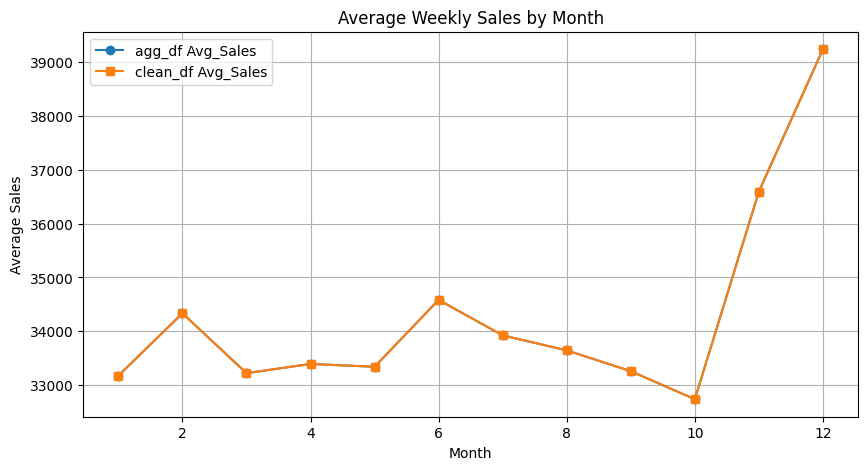

In [60]:
# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Avg Sales from agg_df vs. clean_df monthly avg
plt.figure(figsize=(10, 5))
plt.plot(agg_df["Month"], agg_df["Avg_Sales"], marker="o", label="agg_df Avg_Sales")
plt.plot(monthly_sales.index, monthly_sales.values, marker="s", label="clean_df Avg_Sales")
plt.title("Average Weekly Sales by Month")
plt.xlabel("Month")
plt.ylabel("Average Sales")
plt.legend()
plt.grid(True)
plt.show()

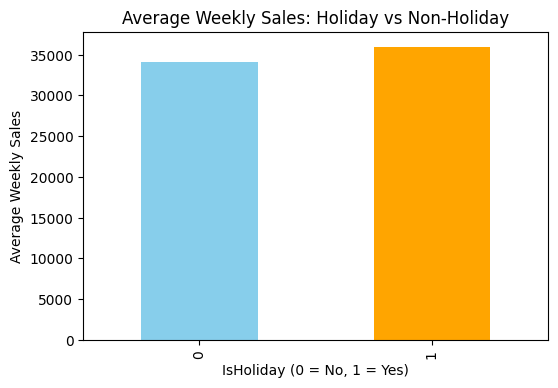

In [61]:
# Holiday vs Non-Holiday sales
plt.figure(figsize=(6, 4))
holiday_sales.plot(kind="bar", color=["skyblue", "orange"])
plt.title("Average Weekly Sales: Holiday vs Non-Holiday")
plt.xlabel("IsHoliday (0 = No, 1 = Yes)")
plt.ylabel("Average Weekly Sales")
plt.show()

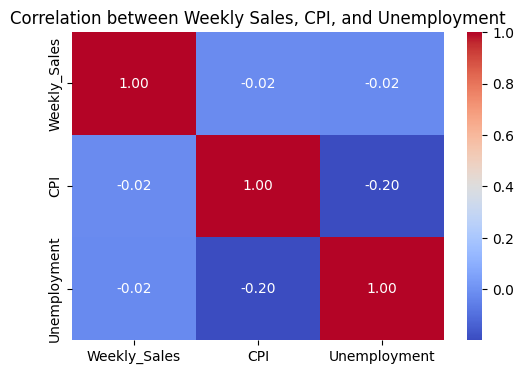

In [62]:
# Correlation heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Weekly Sales, CPI, and Unemployment")
plt.show()

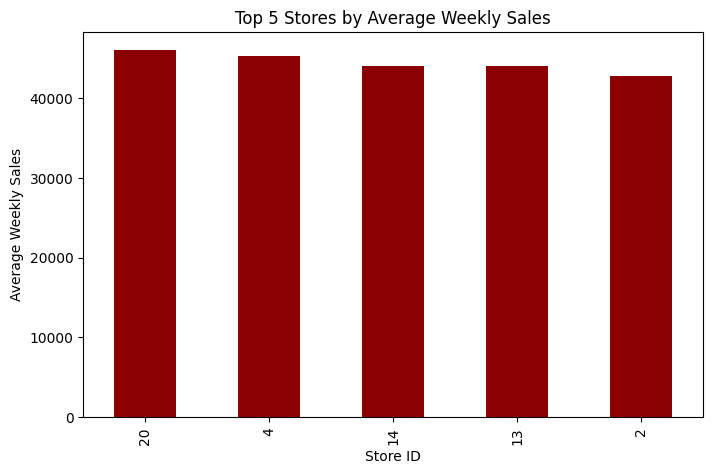

In [66]:
# Top 5 stores by average sales
plt.figure(figsize=(8, 5))
top5_stores.plot(kind="bar", color="darkred")
plt.title("Top 5 Stores by Average Weekly Sales")
plt.xlabel("Store ID")
plt.ylabel("Average Weekly Sales")
plt.show()

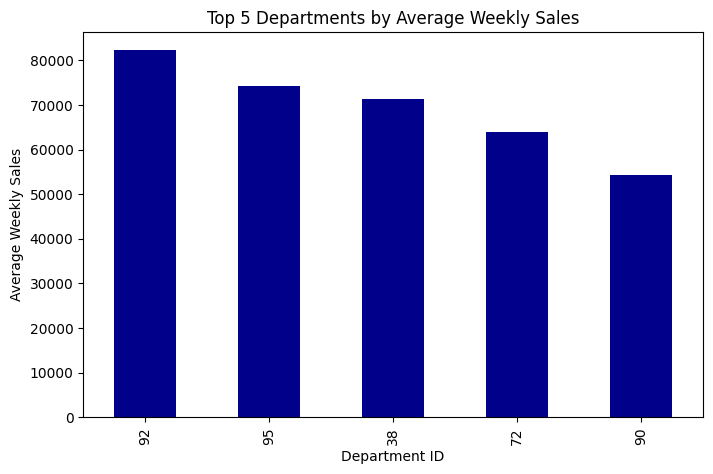

In [67]:
# Top 5 departments by average sales
plt.figure(figsize=(8, 5))
top5_depts.plot(kind="bar", color="darkblue")
plt.title("Top 5 Departments by Average Weekly Sales")
plt.xlabel("Department ID")
plt.ylabel("Average Weekly Sales")
plt.show()

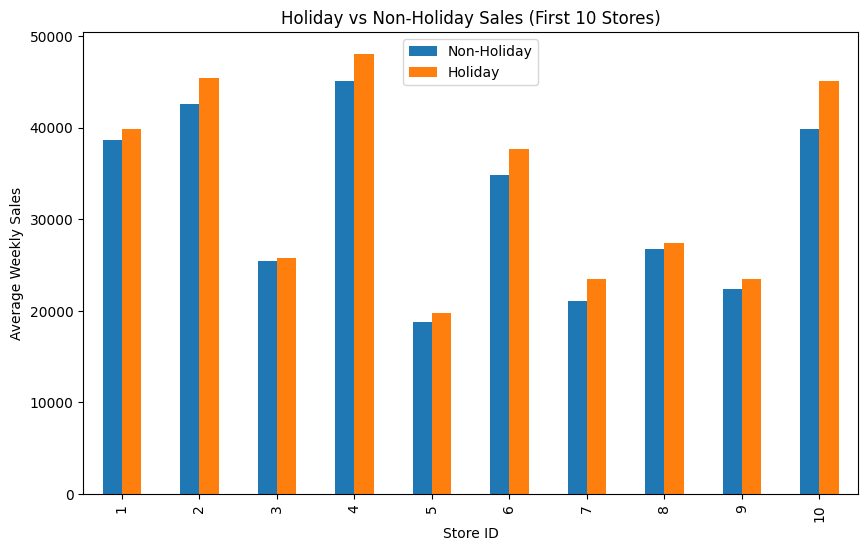

In [65]:
# Holiday vs Non-Holiday by Store (sample of first 10 stores for clarity)
holiday_store_sample = holiday_store.head(10)
holiday_store_sample.plot(kind="bar", figsize=(10, 6))
plt.title("Holiday vs Non-Holiday Sales (First 10 Stores)")
plt.xlabel("Store ID")
plt.ylabel("Average Weekly Sales")
plt.legend(["Non-Holiday", "Holiday"])
plt.show()